## Import librerie e inizializzazione dello Spark Context

In [1]:
from pyspark.ml import Pipeline

from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LinearSVC
from pyspark.mllib.tree import DecisionTree as DT
from pyspark.mllib.tree import DecisionTreeModel, LabeledPoint

from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql import Row

from pyspark.sql.types import IntegerType

import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pandas as pd

from sklearn import neighbors

from pyspark import SparkContext
sc = SparkContext.getOrCreate()

spark = SparkSession.builder.getOrCreate()

In [2]:
data = spark.read.option("header",True).option('inferSchema', True).json("no_outlier_KMeans_v3.json")

### definizione funzioni

In [3]:
def getAppeal(value):
    """
    Defines target variable
    """
    if float(value) >= 3.5:
        return 1
    else:
        return 0

def save_clf(clf, version, directory='models'):
    """
    Saves classifier to models directory
    """
    if not os.path.isdir(directory):
        os.mkdir(directory)
        print(f"Directory {directory} created")
    
    filename = f'{directory}/{str(type(clf)).split(".")[-1][:-2]}-{version}.model'

    if not os.path.isfile(filename):
        clf.save(filename)
        print('Model saved:', filename)
    else:
        print('File already exists:', filename)
        
def load_clf(base, filename, directory='models'):
    """
    Loads MLib clfier
    """
    file = os.path.join(directory, filename)

    clf = base.load(file)
    print('Model loaded:', filename)
    return clf

def grid_search(train, model, paramGrid):
    crossval = CrossValidator(estimator=model,
                      estimatorParamMaps=paramGrid,
                      evaluator=BinaryClassificationEvaluator().setLabelCol("Appeal"),
                      numFolds=5)  # imposto a 5 per la 5-fold cv
    fit_model = crossval.fit(train)
    print(fit_model)
    bestModel = fit_model.bestModel
    return bestModel

def get_params(model, params):
    """
    Prints model parameters
    """
    extract_par = model.extractParamMap()
    best_parameters = {}
    for par in params:
        if model.hasParam(par):
            best_parameters[par] = extract_par[model.getParam(par)]
    print(best_parameters)

def scale_data(data):
    scaler = MinMaxScaler(inputCol='features_classification',outputCol='features_standardized')
    scaled = scaler.fit(data).transform(data)
    return scaled

def my_confusion_matrix(cfm):
    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                cfm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cfm.flatten()/np.sum(cfm)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cfm, annot=labels, fmt="", cmap='Blues')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted',fontsize=12)

def evaluate(predictions):
    """
    Prints evaluation metrics
    Plots confusion matrix
    """
 
    evaluator = BinaryClassificationEvaluator(labelCol="Appeal")
    AUC  = evaluator.evaluate(predictions)
    
    cm = predictions.crosstab("prediction", "Appeal").toPandas()
    
    # calculate 
    TP = cm["1"][0]
    FP = cm["0"][0]
    TN = cm["0"][1]
    FN = cm["1"][1]
    Accuracy = (TP+TN)/(TP+FP+TN+FN)
    Recall = TP/(TP+FN)
    Specificity = TN/(TN+FP)
    Precision = TP/(TP+FP)
    F1 = 2 * ((Precision * Recall)/(Precision + Recall))
    print("Model Performance Measure")
    print ("Accuracy = %0.2f" %Accuracy )
    print ("Specificity = %0.2f" %Specificity )
    print ("Precision = %0.2f" %Precision )
    print ("Recall = %0.2f" %Recall )
    print ("F1-score = %0.2f" %F1 )
    
    print("AUC = %.2f" % AUC)
    
    my_confusion_matrix(np.array([[TN, FP],[ FN, TP]]))

from sklearn.metrics import roc_curve, auc

def plot_ROC(predictions):
    PredAndLabels           = predictions.select("probability", "Appeal")
    PredAndLabels_collect   = PredAndLabels.collect()
    PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
    PredAndLabels           = sc.parallelize(PredAndLabels_list)

    metrics = BinaryClassificationMetrics(PredAndLabels)

    # Area under ROC
    print("Area under ROC = %.2f" % metrics.areaUnderROC)

    # Visualization
    FPR = dict()                                                        # FPR: False Positive Rate
    tpr = dict()                                                        # TPR: True Positive Rate
    roc_auc = dict()

    y_test = [i[1] for i in PredAndLabels_list]
    y_score = [i[0] for i in PredAndLabels_list]

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.draw() 

def extractFeatureImportance(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

### Preprocessing: binarizzazione di rating ed eliminazione features rimaste dal clustering

In [4]:
data = data.withColumn("Appeal", udf(getAppeal)("Rating"))

In [5]:
data = data.withColumn("Quarter_of_Release", data["Quarter_of_Release"].cast(IntegerType()))
data = data.withColumn("Appeal", data["Appeal"].cast(IntegerType()))

In [6]:
data = data.drop("Rating","prediction", "features_cluster", "distances", "standardized", "position")

### Assembling

In [7]:
features_classification = ["Age","EditorsChoice",
                           "AdSupported","InApp", "Price",
                           "Year_of_Release","Quarter_of_Release",
                           "Price_stdev_from_Category", "Year_of_Last_Update"]

#,
#,
                          #"Installs_stdev_from_Category"] #, "Installs"]

In [8]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=features_classification, outputCol='features_classification')

data = assembler.transform(data)

In [9]:
#data.select('features_classification').show(10)

### Prova CrossGenre

In [10]:
data.select('Category').distinct().show(100)

+--------------------+
|            Category|
+--------------------+
|       Music & Audio|
|           Education|
|              Trivia|
|     Auto & Vehicles|
|       Entertainment|
|           Adventure|
|              Arcade|
|              Sports|
|      Travel & Local|
|        Food & Drink|
|        Role Playing|
|             Finance|
|     Personalization|
|              Racing|
|               Tools|
|         Educational|
|              Comics|
|              Social|
|    Libraries & Demo|
|            Shopping|
|    Health & Fitness|
|        House & Home|
|        Productivity|
|                Card|
|              Casino|
|               Music|
|         Photography|
|              Events|
|           Lifestyle|
|            Business|
|    News & Magazines|
|Video Players & E...|
|   Books & Reference|
|              Dating|
|             Weather|
|              Puzzle|
|              Casual|
|               Board|
|             Medical|
|           Parenting|
|       Com

In [11]:
category_train = 'News & Magazines' # categoria principale di addestramento
category_test = 'Books & Reference' # categoria su cui si vuole testare

# modello (deve avere labelCol=Appeal e featuresCol='features_classification')
# non deve essere fittato (non mettere .fit())
# si possono impostare anche altri parametri
# ad es, nel caso del decision tree potremmo mettere:
# impurity='gini', maxDepth=5, maxBins=15

# opzionalmente, si può definire una paramGrid e darla in pasto alla pipeline, che effettuerà anche la grid
# se non si vuole fare grid search, lasciare paramGrid=None

In [12]:
category_train = 'Arcade' # categoria principale di addestramento
category_test = 'Casual' # categoria su cui si vuole testare

print('Filtering...')
data_ctrain = data.filter(data.Category == category_train)
data_ctest = data.filter(data.Category == category_test)
print('Dataframe of size', data_ctrain.count(), "for category:", category_train)

print('Train-test split...')
train, test = data_ctrain.randomSplit([0.7, 0.3], seed=0)

# set the model
model = LinearSVC(labelCol="Appeal", featuresCol="features_classification")
# set parameter grid
paramGrid = ParamGridBuilder()\
    .addGrid(model.tol, [1e-06, 1e-05, 1e-04,1e-03, 1e-07, 1e-08]) \
    .addGrid(model.regParam, [0.0, 0.01, 0.1 ])\
    .addGrid(model.fitIntercept, [True, False])\
    .build()
    
print('Executing grid search, fitting the model...')
model = grid_search(train, model, paramGrid)



Filtering...
Dataframe of size 47170 for category: Arcade
Train-test split...
Executing grid search, fitting the model...
CrossValidatorModel_a3c12c07cd55


Predicting on test set (Arcade)
Evaluating on test set(Arcade)
Model Performance Measure
Accuracy = 0.56
Specificity = 0.85
Precision = 0.67
Recall = 0.29
F1-score = 0.40
AUC = 0.62


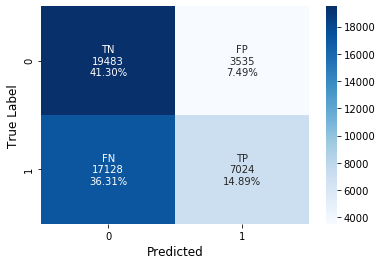

In [14]:
print(f'Predicting on test set ({category_train})')
predictions1 = model.transform(data_ctrain)
print(f'Evaluating on test set({category_train})')
evaluate(predictions1)


Predicting on test set (Casual)
Evaluating on test set(Casual)
Model Performance Measure
Accuracy = 0.58
Specificity = 0.85
Precision = 0.68
Recall = 0.32
F1-score = 0.44
AUC = 0.66


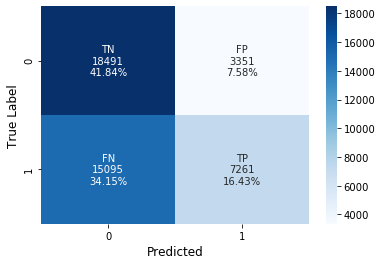

In [15]:
print(f'Predicting on test set ({category_test})')
predictions2 = model.transform(data_ctest)
print(f'Evaluating on test set({category_test})')
evaluate(predictions2)


In [16]:
#plot_ROC(predictions1)
#plot_ROC(predictions2)

AnalysisException: cannot resolve '`probability`' given input columns: [AdSupported, Age, AppId, AppName, Appeal, Category, DeveloperId, EditorsChoice, InApp, Installs, Installs_stdev_from_Category, MinAndroid, Price, Price_stdev_from_Category, Quarter_of_Release, Rating_Reviews_Ratio, Rating_stdev_from_Category, Reviews_Installs_Ratio, Size, Size_stdev_from_Category, Year_of_Last_Update, Year_of_Release, features_classification, nReviews, nReviews_stdev_from_Category, prediction, rawPrediction];
'Project ['probability, Appeal#128]
+- Project [AdSupported#7, Age#8L, AppId#9, AppName#10, Category#11, DeveloperId#12, EditorsChoice#13, InApp#14, Installs#15, Installs_stdev_from_Category#16, MinAndroid#17, Price#18, Price_stdev_from_Category#19, Quarter_of_Release#97, Rating_Reviews_Ratio#22, Rating_stdev_from_Category#23, Reviews_Installs_Ratio#24, Size#25, Size_stdev_from_Category#26, Year_of_Last_Update#27L, Year_of_Release#28L, nReviews#31, nReviews_stdev_from_Category#32, Appeal#128, ... 3 more fields]
   +- Project [AdSupported#7, Age#8L, AppId#9, AppName#10, Category#11, DeveloperId#12, EditorsChoice#13, InApp#14, Installs#15, Installs_stdev_from_Category#16, MinAndroid#17, Price#18, Price_stdev_from_Category#19, Quarter_of_Release#97, Rating_Reviews_Ratio#22, Rating_stdev_from_Category#23, Reviews_Installs_Ratio#24, Size#25, Size_stdev_from_Category#26, Year_of_Last_Update#27L, Year_of_Release#28L, nReviews#31, nReviews_stdev_from_Category#32, Appeal#128, ... 2 more fields]
      +- Filter (Category#11 = Arcade)
         +- Project [AdSupported#7, Age#8L, AppId#9, AppName#10, Category#11, DeveloperId#12, EditorsChoice#13, InApp#14, Installs#15, Installs_stdev_from_Category#16, MinAndroid#17, Price#18, Price_stdev_from_Category#19, Quarter_of_Release#97, Rating_Reviews_Ratio#22, Rating_stdev_from_Category#23, Reviews_Installs_Ratio#24, Size#25, Size_stdev_from_Category#26, Year_of_Last_Update#27L, Year_of_Release#28L, nReviews#31, nReviews_stdev_from_Category#32, Appeal#128, UDF(struct(Age_double_VectorAssembler_1e76a3ea1920, cast(Age#8L as double), EditorsChoice_double_VectorAssembler_1e76a3ea1920, cast(EditorsChoice#13 as double), AdSupported_double_VectorAssembler_1e76a3ea1920, cast(AdSupported#7 as double), InApp_double_VectorAssembler_1e76a3ea1920, cast(InApp#14 as double), Price, Price#18, Year_of_Release_double_VectorAssembler_1e76a3ea1920, cast(Year_of_Release#28L as double), Quarter_of_Release_double_VectorAssembler_1e76a3ea1920, cast(Quarter_of_Release#97 as double), Price_stdev_from_Category, Price_stdev_from_Category#19, Year_of_Last_Update_double_VectorAssembler_1e76a3ea1920, cast(Year_of_Last_Update#27L as double))) AS features_classification#191]
            +- Project [AdSupported#7, Age#8L, AppId#9, AppName#10, Category#11, DeveloperId#12, EditorsChoice#13, InApp#14, Installs#15, Installs_stdev_from_Category#16, MinAndroid#17, Price#18, Price_stdev_from_Category#19, Quarter_of_Release#97, Rating_Reviews_Ratio#22, Rating_stdev_from_Category#23, Reviews_Installs_Ratio#24, Size#25, Size_stdev_from_Category#26, Year_of_Last_Update#27L, Year_of_Release#28L, nReviews#31, nReviews_stdev_from_Category#32, Appeal#128]
               +- Project [AdSupported#7, Age#8L, AppId#9, AppName#10, Category#11, DeveloperId#12, EditorsChoice#13, InApp#14, Installs#15, Installs_stdev_from_Category#16, MinAndroid#17, Price#18, Price_stdev_from_Category#19, Quarter_of_Release#97, Rating#21, Rating_Reviews_Ratio#22, Rating_stdev_from_Category#23, Reviews_Installs_Ratio#24, Size#25, Size_stdev_from_Category#26, Year_of_Last_Update#27L, Year_of_Release#28L, distances#29, features_cluster#30, ... 6 more fields]
                  +- Project [AdSupported#7, Age#8L, AppId#9, AppName#10, Category#11, DeveloperId#12, EditorsChoice#13, InApp#14, Installs#15, Installs_stdev_from_Category#16, MinAndroid#17, Price#18, Price_stdev_from_Category#19, cast(Quarter_of_Release#20 as int) AS Quarter_of_Release#97, Rating#21, Rating_Reviews_Ratio#22, Rating_stdev_from_Category#23, Reviews_Installs_Ratio#24, Size#25, Size_stdev_from_Category#26, Year_of_Last_Update#27L, Year_of_Release#28L, distances#29, features_cluster#30, ... 6 more fields]
                     +- Project [AdSupported#7, Age#8L, AppId#9, AppName#10, Category#11, DeveloperId#12, EditorsChoice#13, InApp#14, Installs#15, Installs_stdev_from_Category#16, MinAndroid#17, Price#18, Price_stdev_from_Category#19, Quarter_of_Release#20, Rating#21, Rating_Reviews_Ratio#22, Rating_stdev_from_Category#23, Reviews_Installs_Ratio#24, Size#25, Size_stdev_from_Category#26, Year_of_Last_Update#27L, Year_of_Release#28L, distances#29, features_cluster#30, ... 6 more fields]
                        +- Relation[AdSupported#7,Age#8L,AppId#9,AppName#10,Category#11,DeveloperId#12,EditorsChoice#13,InApp#14,Installs#15,Installs_stdev_from_Category#16,MinAndroid#17,Price#18,Price_stdev_from_Category#19,Quarter_of_Release#20,Rating#21,Rating_Reviews_Ratio#22,Rating_stdev_from_Category#23,Reviews_Installs_Ratio#24,Size#25,Size_stdev_from_Category#26,Year_of_Last_Update#27L,Year_of_Release#28L,distances#29,features_cluster#30,... 5 more fields] json


In [ ]:
extractFeatureImportance(model.featureImportances, data_ctest, 'features_classification')

In [17]:
category_train = 'Casual' # categoria principale di addestramento
category_test = 'Arcade' # categoria su cui si vuole testare

print('Filtering...')
data_ctrain = data.filter(data.Category == category_train)
data_ctest = data.filter(data.Category == category_test)
print('Dataframe of size', data_ctrain.count(), "for category:", category_train)

print('Train-test split...')
train, test = data_ctrain.randomSplit([0.7, 0.3], seed=0)

# set the model
model = LinearSVC(labelCol="Appeal", featuresCol="features_classification")
# set parameter grid
paramGrid = ParamGridBuilder()\
    .addGrid(model.tol, [1e-06, 1e-05, 1e-04,1e-03, 1e-07, 1e-08]) \
    .addGrid(model.regParam, [0.0, 0.01, 0.1 ])\
    .addGrid(model.fitIntercept, [True, False])\
    .build()
    
print('Executing grid search, fitting the model...')
model = grid_search(train, model, paramGrid)



Filtering...
Dataframe of size 44198 for category: Casual
Train-test split...
Executing grid search, fitting the model...
CrossValidatorModel_82ccc37560e7


In [18]:
params = ['impurity', 'maxDepth', 'maxBins']
get_params(model, params)

{}


Predicting on test set (Casual)
Evaluating on test set(Casual)
Model Performance Measure
Accuracy = 0.51
Specificity = 0.00
Precision = 0.51
Recall = 1.00
F1-score = 0.67
AUC = 0.65


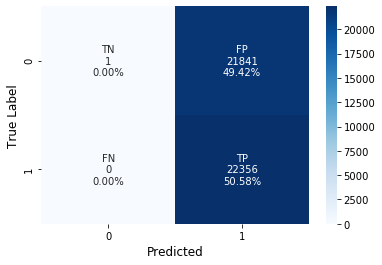

In [19]:
print(f'Predicting on test set ({category_train})')
predictions1 = model.transform(data_ctrain)
print(f'Evaluating on test set({category_train})')
evaluate(predictions1)


Predicting on test set (Arcade)
Evaluating on test set(Arcade)
Model Performance Measure
Accuracy = 0.51
Specificity = 0.00
Precision = 0.51
Recall = 1.00
F1-score = 0.68
AUC = 0.61


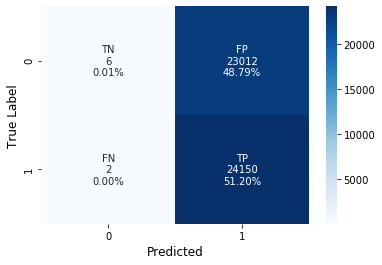

In [20]:
print(f'Predicting on test set ({category_test})')
predictions2 = model.transform(data_ctest)
print(f'Evaluating on test set({category_test})')
evaluate(predictions2)


In [ ]:
plot_ROC(predictions1)
plot_ROC(predictions2)

In [ ]:
extractFeatureImportance(model.featureImportances, data_ctest, 'features_classification')

In [ ]:
data_ctest.crosstab('Appeal','AdSupported').show()

In [ ]:
category_train = 'Casual' # categoria principale di addestramento
category_test = 'Arcade' # categoria su cui si vuole testare

print('Filtering...')
data_ctrain = data.filter(data.Category == category_train)
data_ctest = data.filter(data.Category == category_test)
print('Dataframe of size', data_ctrain.count(), "for category:", category_train)

print('Train-test split...')
train, test = data_ctrain.randomSplit([0.7, 0.3], seed=0)

# set the model
model = LinearSVC(labelCol="Appeal", featuresCol="features_classification")
# set parameter grid
paramGrid = ParamGridBuilder()\
    .addGrid(model.tol, [1e-06, 1e-05, 1e-04,1e-03, 1e-07, 1e-08]) \
    .addGrid(model.regParam, [0.0, 0.01, 0.1 ])\
    .addGrid(model.fitIntercept, [True, False])\
    .build()
    
print('Executing grid search, fitting the model...')
model = grid_search(train, model, paramGrid)



In [21]:
category_train = 'Education' # categoria principale di addestramento
category_test = 'Music & Audio' # categoria su cui si vuole testare

print('Filtering...')
data_ctrain = data.filter(data.Category == category_train)
data_ctest = data.filter(data.Category == category_test)
print('Dataframe of size', data_ctrain.count(), "for category:", category_train)

print('Train-test split...')
train, test = data_ctrain.randomSplit([0.7, 0.3], seed=0)

# set the model
model = LinearSVC(labelCol="Appeal", featuresCol="features_classification")
# set parameter grid
paramGrid = ParamGridBuilder()\
    .addGrid(model.tol, [1e-06, 1e-05, 1e-04,1e-03, 1e-07, 1e-08]) \
    .addGrid(model.regParam, [0.0, 0.01, 0.1 ])\
    .addGrid(model.fitIntercept, [True, False])\
    .build()
    
print('Executing grid search, fitting the model...')
model = grid_search(train, model, paramGrid)



Filtering...
Dataframe of size 226114 for category: Education
Train-test split...
Executing grid search, fitting the model...
CrossValidatorModel_38394b088620


Predicting on test set (Education)
Evaluating on test set(Education)
Model Performance Measure
Accuracy = 0.57
Specificity = 0.64
Precision = 0.55
Recall = 0.50
F1-score = 0.52
AUC = 0.65


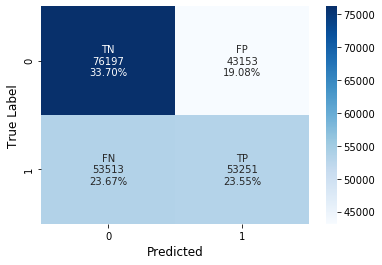

In [22]:
print(f'Predicting on test set ({category_train})')
predictions1 = model.transform(data_ctrain)
print(f'Evaluating on test set({category_train})')
evaluate(predictions1)


Predicting on test set (Music & Audio)
Evaluating on test set(Music & Audio)
Model Performance Measure
Accuracy = 0.48
Specificity = 0.19
Precision = 0.47
Recall = 0.79
F1-score = 0.59
AUC = 0.61


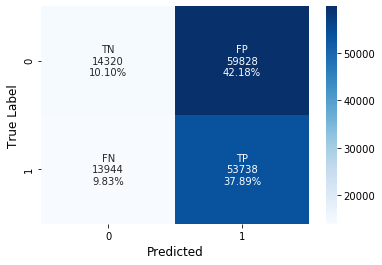

In [23]:
print(f'Predicting on test set ({category_test})')
predictions2 = model.transform(data_ctest)
print(f'Evaluating on test set({category_test})')
evaluate(predictions2)
